# Week 3: direct-sampling Monte Carlo integration



After last week's recap of probability theory and random variables, it is time to apply this knowledge to understand the applicability and shortcomings of Monte Carlo methods. Before heading in that direction let us add one more method to our toolbox to sample random variables.

### Acceptance-Rejection sampling

Suppose we wish to sample a continuous random variable $X$ with probability density function $f_X(x)$. Last week we have seen that one way to achieve this is via the **inverse method** by applying the inverse cumulative distribution function $F_X^{-1}$ to a uniform random variable $U$ on $(0,1)$. But this requires that we have an efficient way to calculate $F_X^{-1}(p)$ for any real number $p\in(0,1)$. In many case a closed-form expression for $F_X$ is not available, let alone for its inverse, so one has to resort to costly numerical approximations. Applying the inverse method to joint distributions of several random variables becomes even more challenging. We also discussed **change of variables** as a method to generate particular distributions, but discovering suitable transformations requires some luck and ingenuity. 

A more generally applicable method, that may or may not be efficient, is **acceptance-rejection sampling**. Suppose there is another random variable $Z$ with density $f_Z(x)$ that we already know how to sample efficiently and that $f_Z(x)$ and $f_X(x)$ are not too dissimilar. More precisely, suppose we can find a $c \geq 1$ such that $f_X(x) \leq c\,f_Z(x)$ for all $x\in\mathbb{R}$. Then we can sample $X$ using the following simple algorithm. Here `sample_z` is a function sampling $Z$ and `accept_probability` is the function $x\to f_X(x) / (c f_Z(x))$.

In [1]:
import numpy as np
rng = np.random.default_rng()   

def sample_acceptance_rejection(sample_z,accept_probability):
    while True:
        x = sample_z()
        if rng.random() < accept_probability(x):
            return x

Why does this work? It is useful to assign a geometric interpretation to this sampling procedure. Let $U$ be  uniform random in $(0,1)$ independent of $X$. The point $(X,Y) = (X,U f_X(X))$ is then uniform in the region $S_X=\{ (x,y) : x\in \mathbb{R},\,0< y< f_X(x)\}$ enclosed by the graph of $f_X$ and the $x$-axis. To see this we note that $(x,u) \to (x,y) = (x,u f_X(x))$ is a differentiable and invertible mapping (at least where $f_X(x)\neq 0$) and we can therefore relate the joint densities by change of variables: $f_X(x) \mathrm{d}x \mathrm{d}u =\mathrm{d}x\mathrm{d}y$ for $(x,y) \in S_X$, so $f_{X,Y} = \mathbf{1}_{S_X}$. One way to sample $(X,Y)$ is by sampling from a larger but simpler region containing $S_X$ and rejecting any sample that is not in $S_X$. If we have another random variable $Z$ and constant $c\geq 1$ satisfying $f_X(x) \leq c\,f_Z(x)$ then a natural region is $c S_Z = \{(x,cy) : x\in\mathbb{R}, 0<y<f_Z(x)\}$, because $S_X \subset c S_Z$. If we sample $Z$ and an independent $U'$ uniform in $(0,1)$, then the conditional distribution of $(Z,U' c f_Z(Z))$ given the event $(Z,U' c f_Z(Z))\in S_X$ is uniform in $S_X$. On that event $Z$ is therefore identically distributed to $X$. The natural way to sample a random variable conditionally on an event, is simply to repeat the sampling until the event occurs. Given $Z=z$ this event occurs with probability $\mathbb{P}(U' c f_Z(Z) < f_X(Z) | Z=z) = f_X(Z) / (c f_Z(Z))$, so we should repeatedly sample $Z$ and accept the value with this probability. This is precisely what the algorithm above does.

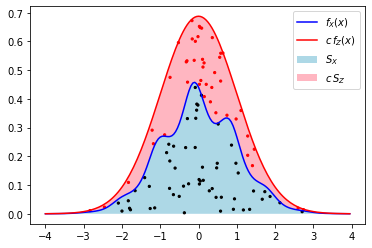

How efficient is this algorithm? At each iteration the acceptance probability is $$\mathbb{P}(U' c f_Z(Z) < f_X(Z)) = \int_{-\infty}^\infty \mathrm{d}z f_Z(z) \mathbb{P}(U' c f_Z(Z) < f_X(Z) | Z=z) = \int_{-\infty}^\infty \mathrm{d}z f_X(z)/c = 1/c.$$
This means that the number of iterations needed is a random number $N\geq 1$ with probability mass function $p_N(n) = 1/c\,(1-1/c)^{n-1}$, i.e. a **geometric random** variable with parameter $1-1/c$. The expected number of samples required is then simply $\mathbb{E}[N] = c$. So we should make sure $c$ is not too large, since the average runtime of a simulation that relies heavily on sampling $X$ scales linearly with $c$.

A bonus of this method is that you only really need to know the probability density $f_X(x)$ up to an overall constant, the conditioning in the method takes care of the proper normalization. As an example, suppose we wish to sample $X$ with distribution $f_X(x) = C/\cosh(x^2-1)$, but we do not know the normalization constant. However, we can convince ourselves that $1/\cosh(x^2-1) \leq 6 f_{\mathcal{N}}(x)$, so we can apply acceptance-rejection to a standard normal random variable $\mathcal{N}$ with $c = 6C$. Luckily $C$ cancels out in the acceptance probability $f_X(x) / (c f_{\mathcal{N}}(x))$, so we can proceed as follows.

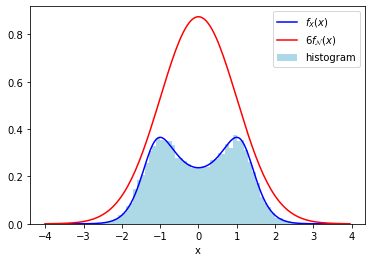

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

def difficult_pdf(x):
    return 1/np.cosh(x**2-1)

def gaussian(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

def accept(x):
    return difficult_pdf(x)/(6*gaussian(x))

samples = [sample_acceptance_rejection(rng.normal,accept) for _ in range(20000)]

# for plotting purposes let's compute C
from scipy.integrate import quad
normalization_C = 1/quad(difficult_pdf, -20, 20)[0]

xrange = np.arange(-4,4,0.05)
plt.plot(xrange,normalization_C*difficult_pdf(xrange),'-b')
plt.plot(xrange,normalization_C*6*gaussian(xrange),'-r')
plt.hist(samples,bins=np.arange(-4,4,0.1),density=True,color="lightblue")
plt.legend([r"$f_X(x)$",r"$6f_{\mathcal{N}}(x)$","histogram"])
plt.xlabel("x")
plt.show()

The method generalizes straightforwardly to discrete random variables (where one needs a bound $p_X(x) \leq c\,p_Z(x)$ on the probability mass functions) and to multivariate distributions. Note however that as the number of dimensions increases it will become increasingly difficult to keep the constant $c$ relatively small. 

## Monte Carlo integration: direct-sampling

A straightforward application of Monte Carlo methods is the evaluation of integrals of the form
$$I=\int_{-\infty}^\infty g(y) f_Y(y)\mathrm{d}y,$$
where $f_Y(y)$ is some function integrating to $\int_{-\infty}^\infty f_Y(y)\mathrm{d}y = 1$. As a special case we can consider $f_Y(y) = \frac{1}{b-a}\mathbf{1}_{\{a<y<b\}}$ to be the probability density of the uniform random variable on $(a,b)$, such that the integral simply becomes the definite integral
$$I=\frac{1}{b-a} \int_a^b g(y)\mathrm{d}y.$$
The basic idea is of Monte Carlo integration is to interpret the integral as the expectation value of the random variable $X=g(Y)$,
$$I = \mathbb{E}[g(Y)] = \mathbb{E}[X].$$
We know from last week's considerations how to approximate this expectation value by considering the **sample mean** $$\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_i.$$ It is an **unbiased estimator** of $\mathbb{E}[X]$ in the sense that $\mathbb{E}[\bar{X}_n] = \mathbb{E}[X]$. 
According to the **weak law of large numbers** the sample mean $\bar{X}_n$ indeed approaches $\mathbb{E}[X]$ in the sense of convergence in probability. If we know the variance $\sigma_X^2$ one also obtains an upper-bound on the error $\epsilon$ as
$$ \mathbb{P}( |\bar{X}_n - \mathbb{E}[X]| > \epsilon ) \leq \frac{\sigma_X^2}{n\epsilon^2} \qquad \text{for }\epsilon>0, \,n\geq 1.$$
Equivalently
$$\mathbb{P}( \bar{X}_n - \sigma_X/\sqrt{\delta n} \leq \mathbb{E}[X] \leq \bar{X}_n + \sigma_X/\sqrt{\delta n}) \geq 1- \delta \qquad \text{for any }\delta > 0, \,n\geq 1.$$
For example, after an experiment with $n$ samples we can say that with probability **at least** 0.682 the mean will  lie within distance $1.77 \sigma_X/\sqrt{n}$ of our estimate $\bar{E}_n$.
This bound holds for any $n$, even $n=1$, but is quite conservative when $n$ is large, because it does not take into account that the error approaches a normal distribution. In that limit the **central limit theorem** gives a more tight bound, because we know
$$ \mathbb{P}( |\bar{X}_n - \mathbb{E}[X]| > \frac{\sigma_X}{\sqrt{n}}\epsilon ) \quad\xrightarrow{n\to\infty}\quad \mathbb{P}( | \mathcal{N}| > \epsilon ) = \frac{2}{\sqrt{2\pi}}\int_{\epsilon}^\infty e^{-x^2/2}\mathrm{d}x.$$
This gives the more accurate **1$\sigma$-confidence level**, stating that in the limit of large $n$ with **precisely** $\mathbb{P}(|\mathcal{N}|>1) = 0.682\ldots$ probability we have that 

$$\bar{X}_n - \frac{\sigma_X}{\sqrt{n}} \,\leq\, \mathbb{E}[X] \,\leq\, \bar{X}_n + \frac{\sigma_X}{\sqrt{n}}.\qquad(1\sigma\text{ or }68.2\%\text{ confidence when CLT holds})$$

So knowing that the central limit theorem holds allows us to decrease the error interval by a factor $1.77$ in this case.

Of course, we are cheating a bit here, because generally we do not know the variance $\sigma_X^2$, so it has to be estimated as well. An **unbiased estimator** for the variance is given by **sample variance** 
$$s^2_n = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X}_n)^2,$$
which differs from the usual variance of the sample sequence $X_1,\ldots,X_n$ by a factor $n/(n-1)$. This additional factor ensures that
$$\mathbb{E}[s^2_n] = \sigma^2_X,$$
as you may check by expanding the parentheses and using linearity of expectation. A variation of the weak law of large numbers tells us that $s_n$ really converges in probability to $\sigma_X$ as $n\to\infty$. We may thus substitute the variance by the sample variance in the error estimate without changing the central limit theorem. Hence with the **1$\sigma$-confidence level** can also be written as 

$$\bar{X}_n - \frac{s_n}{\sqrt{n}} \,\leq\, \mathbb{E}[X] \,\leq\, \bar{X}_n + \frac{s_n}{\sqrt{n}}.\qquad(1\sigma\text{ or }68.2\%\text{ confidence when CLT holds})$$

The result of an experiment is thus generally reported as $\mathbb{E}[X] = \bar{X}_n \pm \frac{s_n}{\sqrt{n}}$.

Let's consider an example that is directly related to the direct-sampling pebble game from the first lecture by considering the function $g(x) = \sqrt{1-x^2}$ on $(0,1)$ and estimating $\pi/4$ by Monte Carlo integrating
$$\frac{\pi}{4} = \int_{-\infty}^{\infty} \sqrt{1-x^2}\, \mathbf{1}_{0<x<1}\mathrm{d}x = \mathbb{E}[g(U)],$$
where $U$ is a uniform random variable on $(0,1)$.

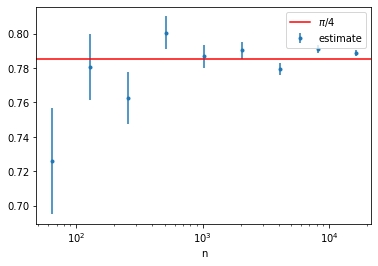

In [3]:
def estimate_expectation(sampler,n):
    '''Compute beste estimate of mean and 1-sigma error with n samples.'''
    samples = [sampler() for _ in range(n)]
    return np.mean(samples), np.std(samples)/np.sqrt(n-1)

def sample_x():
    return np.sqrt(1-rng.random()**2)

n_range = [2**i for i in range(6,15)]
estimates = np.array([estimate_expectation(sample_x,n) for n in n_range])
plt.errorbar(n_range,estimates[:,0],yerr=estimates[:,1],fmt='.')
plt.axhline(np.pi/4,c='r')
plt.xscale('log')
plt.legend([r"$\pi/4$","estimate"])
plt.xlabel("n")
plt.show()

Note that here we generated all samples, stored them in a list, and then calculated the sample mean and variance. This can become inconvenient when dealing with a very large number of samples. Is there a way to calculate these quantities without storing the samples? The first approach that comes to mind is to keep track of the partial sums $\sum_{i=1}^k X_i$ and $\sum_{i=1}^k X_i^2$, since then at the end we could calculate 
$$s_n^2 = \frac{1}{n-1}\sum_{i=1}^n X_i^2 - \frac{1}{n(n-1)}\left(\sum_{i=1}^n X_i\right)^2.$$
Both terms however can be large and almost equal in magnitude, leading to large cancellations and depending on your programming language and machine precision to round-off errors dominating the answer. A **numerically stable one-pass algorithm** is obtained by keeping track of $\bar{X}_k = \frac{1}{k}\sum_{i=1}^k X_i$ and $S_k = \sum_{i=1}^k (X_i - \bar{X}_k)^2$, which satisfy
$$ \bar{X}_k = \bar{X}_{k-1} + \frac{1}{k}\delta_k, \qquad S_k = S_{k-1} + \frac{k-1}{k} \delta_k^2, \qquad \delta_k:= X_k - \bar{X}_{k-1},\qquad\text{for }k\geq 1,$$
with the convention $\bar{X}_0 = S_0 = 0$. In particular, the following algorithm produces the same results (up to tiny rounding errors) as the previous method, without storing any samples.

In [4]:
def estimate_expectation_one_pass(sampler,n):
    sample_mean = sample_square_dev = 0.0
    for k in range(1,n+1):
        delta = sampler() - sample_mean
        sample_mean += delta / k
        sample_square_dev += (k-1)*delta*delta/k  
    return sample_mean, np.sqrt(sample_square_dev / (n*(n-1)))

To summarize, we have described an algorithm to approximate a definite integral which requires $n$ steps to get an error of order $n^{-1/2}$. Should we be cheering? Not exactly. An error of $O(n^{-1/2})$ is actually pretty bad for a $1$-dimensional integral. For instance, if the integrand has a continuous second-order derivative, then numerical Riemann integration using the [midpoint method](https://en.wikipedia.org/wiki/Midpoint_method) on $n$ evenly spaced points yields an error of order $O(n^{-2})$. In situations where the integrand is not smooth, Monte Carlo integration can become competitive. But the most important point is that our derivation of the error $\sigma_X/\sqrt{n}$ in the Monte Carlo integration was **independent of the dimensionality** of the integral. Extending numerical Riemann integration to $d$-dimensional integrals requires $d$-dimensional grids of points to perform the appropriate interpolations, resulting in an error of order $O(n^{-2/d})$ in the number $n$ of points. The great value of Monte Carlo thus lies in attacking high-dimensional integrals.

### Variance reduction: importance sampling

It is all good and well that an error of $O(n^{-1/2})$ can be competitive compared to other approaches (especially in higher dimensions), but if the multiplicative factor $\sigma_X$ in front is huge we are still in trouble. If $g(x)$ is close to zero in a large part of the domain, then intuitively we expect the Monte Carlo integration to be wasteful, because most of the samples will yield little contribution to the sample mean $\bar{X}_n$. To make this quantitative we can calculate the relative variance as
$$\sigma_X^2 = \int_{-\infty}^\infty \left(g(y)-\mathbb{E}[X]\right)^2 f_Y(y)\mathrm{d}y.$$
It vanishes when $g(y)$ is constant (and thus equal to $\mathbb{E}[X]$) and can be very large if $g(y)$ is very localized. The situation can be improved by changing the distribution of the random variables used. In particular, if $Z$ is a random variable with density $f_Z(y)$ that vanishes only when $f_Y(y)$ vanishes, then we can write
$$ \mathbb{E}[X] = \int_{-\infty}^\infty g(y)f_Y(y)\mathrm{d}y = \int_{-\infty}^\infty \frac{g(y)f_Y(y)}{f_Z(y)} f_Z(y)\mathrm{d}y = \mathbb{E}\left[\frac{g(Z)f_Y(Z)}{f_Z(Z)}\right].$$
What we have done is replacing the random variable $Y$ by another random variable $Z$ and the function $g(x)$ by $g(x) f_Y(x)/f_Z(x)$ without changing the expectation value, $\mathbb{E}[X] = \mathbb{E}[X']$ where $X' = \frac{g(Z)f_Y(Z)}{f_Z(Z)}$. The variance however has changed, because now
$$\sigma_{X'}^2 = \int_{-\infty}^\infty \left(\frac{g(z)f_Y(z)}{f_Z(z)}-\mathbb{E}[X]\right)^2 f_Z(z)\mathrm{d}z.$$
The strategy is then to choose $Z$ such that $f_Z(z)$ is as close to being proportional to $g(z)f_Y(z)$ as possible.

As an example let us compute the probability $\mathbb{P}(Y > 3)$ for a normal random variable $Y$ by setting $g(y) = \mathbf{1}_{\{y>3\}}$, i.e.
$$ I = \int_{-\infty}^\infty \mathbf{1}_{\{y>3\}} f_Y(y)\mathrm{d}y = \int_4^{\infty} \frac{1}{2\pi}e^{-y^2/2}\mathrm{d}y.$$

In [12]:
def sample_x_naive():
    normal = rng.normal()
    return 1 if normal > 3 else 0

estimate_expectation_one_pass(sample_x_naive,10000)

(0.0017000000000000045, 0.0004119805490521122)

The standard error is still quite large despite many samples. Instead let us consider the random variable to be $Z$ with PDF $f_Z(x) = e^{-(x-3)} \mathbf{1}_{\{x>3\}}$ and compute $\mathbb{E}[X]=\mathbb{E}[e^{Z-3}f_Y(Z)]$.

In [13]:
def random_exponential():
    return - np.log(rng.random())

def sample_x_faster():
    z = random_exponential() + 3
    return np.exp(z-3-z*z/2)/np.sqrt(2*np.pi)

estimate_expectation_one_pass(sample_x_faster,10000)

(0.0013566488503656408, 1.3584576738384295e-05)

This has reduced our error by a factor of about 30.

Note that it can happen that $\mathbb{E}[X]$ is finite but that one of $\sigma_X^2$ and $\sigma_{X'}^2$ is infinite. In last week's exercises we have seen that having infinite variance can lower the convergence rate of $\bar{X}_n$ to $\mathbb{E}[X]$ in an undesirable way. Importance sampling often provides a useful method to cure such infinite variances. For example, let us try to compute the integral 
$$I = \int_0^1 x^{-\alpha} e^{-x} \mathrm{d}x$$
for $1/2<\alpha<1$. If we take $I = \mathbb{E}[X]$ with $X=U^{-\alpha}e^{-U}$ for a uniform random variable $U$ then the variance $\sigma_X^2 = \infty$. Using importance sampling with $f_Z(x) = (1-\alpha)x^{-\alpha}  \mathbf{1}_{\{0<x<1\}}$, we have
$$I = \frac{1}{1-\alpha}\mathbb{E}\left[e^{-Z}\right],$$
which is the expectation value of a bounded random variable $X' = e^{-Z} / (1-\alpha)$ and hence with finite variance.

In [14]:
def estimate_unbounded_integral(alpha,n):
    def sample_x_prime():
        exponent = 1/(1-alpha)
        z = rng.random()**exponent
        return exponent*np.exp(-z)
    
    return estimate_expectation_one_pass(sample_x_prime,n)

for alpha in np.arange(0.5,1,0.1):
    estimate,error = estimate_unbounded_integral(alpha,10000)
    print("alpha = {:.1f}, I = {:.5f} +- {:.5f}".format(alpha,estimate,error))

alpha = 0.5, I = 1.49220 +- 0.00403
alpha = 0.6, I = 1.95918 +- 0.00501
alpha = 0.7, I = 2.74110 +- 0.00645
alpha = 0.8, I = 4.35852 +- 0.00890
alpha = 0.9, I = 9.26383 +- 0.01460


### Further reading

A thorough resource for this week's material is Chapter 2 of [Art B. Owen, *Monte Carlo theory, methods and examples* (2013)](https://statweb.stanford.edu/~owen/mc/).